In [6]:
import os
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
# Directorio para guardar imágenes
output_dir = "./productos_generados"
os.makedirs(output_dir, exist_ok=True)

In [8]:
# Cargar scheduler
model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")


In [9]:
def generar_imagen_producto(prompt, guidance_scale=7.5, num_inference_steps=50, nombre_archivo="producto.png"):
    image = pipe(prompt=prompt, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps).images[0]
    save_image(image, nombre_archivo)
    return image

# Prompt ejemplo y generación
prompt_1 = "A high-resolution product photo of modern running sneakers on a white background"
imagen_1 = generar_imagen_producto(prompt_1, nombre_archivo="zapatillas_running.png")

# Segundo prompt de ejemplo
prompt_2 = "A luxury leather handbag with gold accents, studio lighting, white background"
imagen_2 = generar_imagen_producto(prompt_2, nombre_archivo="bolso_lujo.png")


  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en ./productos_generados\zapatillas_running.png


  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en ./productos_generados\bolso_lujo.png


In [10]:
# Cargar pipeline de texto a imagen
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
# Función para guardar imágenes
def save_image(image, filename):
    path = os.path.join(output_dir, filename)
    image.save(path)
    print(f"Imagen guardada en {path}")


In [12]:
# Generar imagen de producto a partir de texto
def generar_imagen_producto(prompt, guidance_scale=7.5, num_inference_steps=50, nombre_archivo="producto.png"):
    image = pipe(prompt=prompt, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps).images[0]
    save_image(image, nombre_archivo)
    return image

In [13]:
# Los prompts de ejemplo
prompt_1 = "A high-resolution product photo of modern running sneakers on a white background"
imagen_1 = generar_imagen_producto(prompt_1, nombre_archivo="zapatillas_running.png")

  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en ./productos_generados\zapatillas_running.png


In [14]:
prompt_2 = "A luxury leather handbag with gold accents, studio lighting, white background"
imagen_2 = generar_imagen_producto(prompt_2, nombre_archivo="bolso_lujo.png")

  0%|          | 0/50 [00:00<?, ?it/s]

Imagen guardada en ./productos_generados\bolso_lujo.png


In [15]:
# Cargar pipeline Image-to-Image
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
)
pipe_img2img = pipe_img2img.to("cuda" if torch.cuda.is_available() else "cpu")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
def generar_variacion_imagen(init_image, prompt, strength=0.7, guidance_scale=7.5, num_inference_steps=50, nombre_archivo="variacion.png"):
    from PIL import Image
    # Forzar que init_image sea PIL Image y tamaño correcto:
    if not isinstance(init_image, Image.Image):
        init_image = Image.fromarray(init_image)
    init_image = init_image.convert("RGB").resize((512, 512))

    image = pipe_img2img(
        prompt=prompt,
        image=init_image,  # Asegúrate de usar el parámetro correcto 'image' no 'init_image'
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps
    ).images[0]
    save_image(image, nombre_archivo)
    return image

In [19]:
# Crear variación sobre imagen_1
prompt_variacion = "Same running sneakers but with red stripes and white laces"
imagen_variada = generar_variacion_imagen(imagen_1, prompt_variacion, nombre_archivo="zapatillas_rojas.png")

  0%|          | 0/35 [00:00<?, ?it/s]

Imagen guardada en ./productos_generados\zapatillas_rojas.png


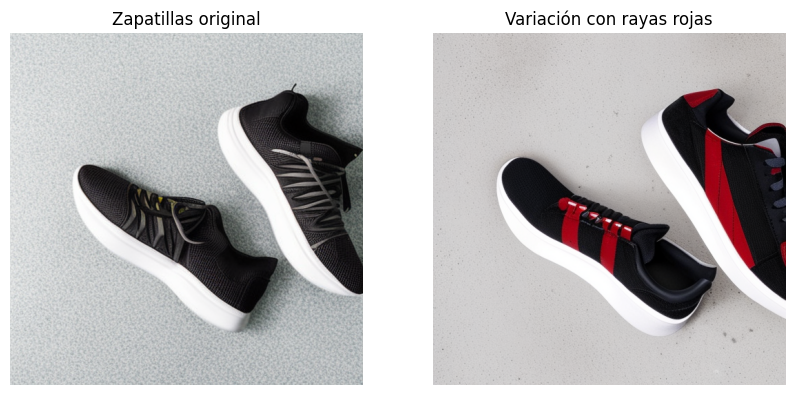

In [20]:
# Mostrar imágenes originales y variación
def mostrar_imagenes(imagenes, titulos=None):
    n = len(imagenes)
    plt.figure(figsize=(5*n,5))
    for i, im in enumerate(imagenes):
        plt.subplot(1, n, i+1)
        plt.imshow(im)
        plt.axis("off")
        if titulos:
            plt.title(titulos[i])
    plt.show()

mostrar_imagenes([imagen_1, imagen_variada], ["Zapatillas original", "Variación con rayas rojas"])